# 04_Otimizacao.ipynb
-------------------------------------
1. Imports e Carregamento do Dataset
-------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import os


-----------------------------------------
2. Carregar os dados limpos da etapa 2
-----------------------------------------

In [2]:
caminho = "../data/processed/delivery_clean.csv"

df = pd.read_csv(caminho)
print(df.shape)
df.head()


(2510, 17)


,delivery_id,distance_km,package_weight_kg,delivery_type,vehicle_type,traffic_condition,weather,time_of_day,day_of_week,driver_experience_years,num_stops,is_priority,package_fragile,delivery_zone,customer_rating,fuel_cost,delivery_time_hours
0,DEL00331,17.62,12.45,Express,Carro,Médio,Ensolarado,Tarde,domingo,5.0,8,No,No,Urbana,3.75,5.41,22.59
1,DEL02382,11.43,3.31,Economy,Carro,Médio,Ensolarado,Manhã,Seg-Qui,8.0,2,No,Yes,Urbana,3.68,5.73,19.18
2,DEL00825,25.87,2.79,Express,Carro,Baixo,Ensolarado,Manhã,Seg-Qui,NaN,1,No,Yes,Urbana,2.98,6.13,3.92
3,DEL00336,14.21,6.99,Standard,Caminhão,Médio,Chuva Forte,Tarde,Domingo,7.0,1,Yes,Yes,Suburbana,2.10,5.34,24.66
4,DEL00551,14.31,NaN,Standard,Van,Alto,Nublado,Manhã,Sábado,1.0,1,No,Yes,Urbana,3.31,6.57,23.05


-------------------------------
3. Separar features e target
-------------------------------

In [3]:
TARGET = "delivery_time_hours"
ID_COLS = ["delivery_id"]

X = df.drop(columns=[TARGET] + ID_COLS)
y = df[TARGET]


------------------------------------
4. Codificar variáveis categóricas
------------------------------------

In [4]:
X = pd.get_dummies(X, drop_first=True)
print("Total de features após encoding:", X.shape[1])


Total de features após encoding: 85


-----------------------------------------
5. Dividir em treino / validação / teste
-----------------------------------------

In [5]:
RANDOM_STATE = 42

# 20% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# 20% validação (25% de 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

print(len(X_train), len(X_val), len(X_test))


1506 502 502


-----------------------------------------
6. Definir o modelo base — Random Forest
-----------------------------------------

In [6]:
modelo = RandomForestRegressor(random_state=42)


----------------------------------------------
7. Criar o espaço de busca de hiperparâmetros
----------------------------------------------

In [7]:
parametros = {
    "n_estimators": [100, 200, 400, 600, 800],
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}


----------------------------
8. Criar o Random Search
----------------------------

In [8]:
random_search = RandomizedSearchCV(
    estimator=modelo,
    param_distributions=parametros,
    n_iter=20,              # 20 combinações aleatórias
    cv=5,                  # k-fold cross validation
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,             # usa todos os núcleos da CPU
    verbose=2
)


---------------------------
9. Treinar o Random Search
---------------------------

In [9]:
random_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:")
random_search.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros encontrados:


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

-------------------------------------------------
10. Treinar o modelo final (treino + validação)
------------------------------------------------

In [10]:
best_params = random_search.best_params_

modelo_final = RandomForestRegressor(
    **best_params,
    random_state=42
)

# juntar treino + validação
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

modelo_final.fit(X_full, y_full)


RandomForestRegressor(max_depth=20, min_samples_split=5, random_state=42)

------------------------------------------
11. Avaliação final no CONJUNTO DE TESTE
------------------------------------------

In [11]:
y_pred = modelo_final.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔎 MÉTRICAS FINAIS NO TESTE")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:  {r2:.4f}")


🔎 MÉTRICAS FINAIS NO TESTE
MAE: 3.2915
RMSE: 4.2073
R²:  0.7908


---------------------------------
12. Gráficos obrigatórios
---------------------------------
Predito vs Real

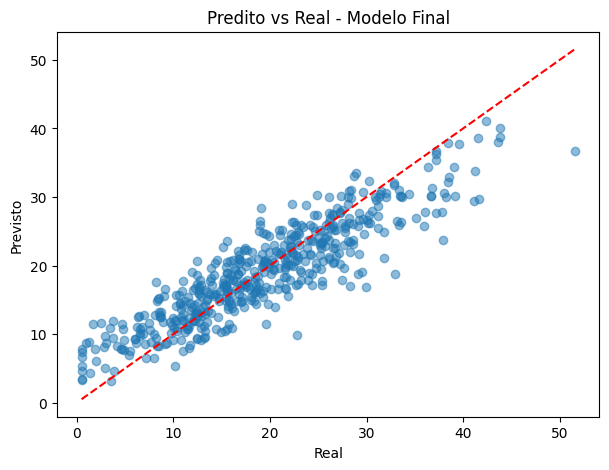

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.title("Predito vs Real - Modelo Final")
plt.show()


- Distribuição dos resíduos

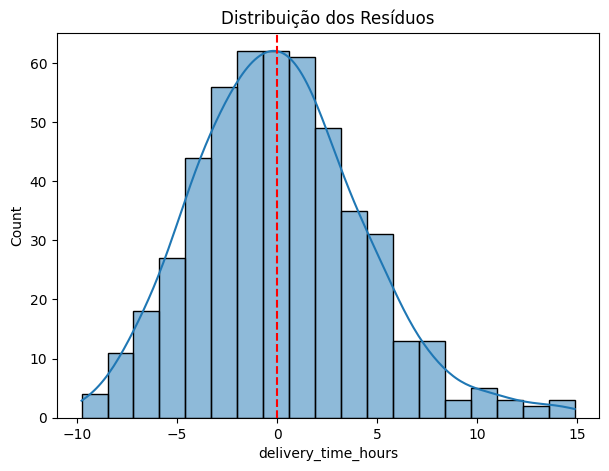

In [13]:
residuos = y_test - y_pred

plt.figure(figsize=(7,5))
sns.histplot(residuos, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuição dos Resíduos")
plt.show()


---------------------------
13. Salvar o modelo final
---------------------------

In [14]:
os.makedirs("../models", exist_ok=True)

joblib.dump(modelo_final, "../models/modelo_final.pkl")

print("Modelo final salvo em models/modelo_final.pkl")


Modelo final salvo em models/modelo_final.pkl
